In [27]:
# GPU selection
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [28]:
import numpy as np
np.random.seed(int(np.pi*10**5)) # Don't be too random on the test suit!

In [29]:
from keras.models import Sequential, Model

In [30]:
from keras.layers import Dense, GRU, LSTM
from keras.layers import Input, TimeDistributed, Embedding, RepeatVector, Lambda, Bidirectional
from keras.layers import Flatten, Reshape, Permute, Activation
from keras.layers import Dot, Concatenate, Multiply
from keras.layers import merge
from keras.callbacks import EarlyStopping
from keras import backend as K

## Preprocessing

Process the text and find the vocabulary size for source input language + create one-hot vectors for all words in target language

In [31]:
src_word_chunker = lambda sent: list(sent)
trg_word_chunker = lambda sent: list(sent)

# depending on the preprocessing that we need we might need different word chunching functions
#src_word_chunker = lambda sent: sent.split()
#trg_word_chunker = lambda sent: sent.split()

#### Read from synthetic tree translation

In [55]:
from konlpy.tag import Twitter
mecab = Twitter()

def get_normalized_data(sentence):
    original_sentence = mecab.pos(sentence)
    inputData = []
    for w, t in original_sentence:
        if t in ['Number']:
            w = '0'
        if t not in ['Punctuation']:
            inputData.append(w)
    return ''.join(inputData)

def get_training_data(sentence):
    original_sentence = mecab.pos(sentence)
    inputData = []
    for w, t in original_sentence:
        if t in ['Number']:
            w = '0'
        if t not in ['Josa']:
            inputData.append(w)
    return ''.join(inputData)

# input_data = []
# for i in text_data:
#     input_data.append(get_training_data(i))

text_read_input =[]
f = open("./text2.txt", 'r', encoding='utf-8')
while True:
    line = f.readline()
    if line == '\n':
        del line
    else:
        text_read_input.append(line)
        if not line: break
f.close()

text_read_input_data = []
for i in text_read_input:
    text_read_input_data.append(get_normalized_data(i))

input_data = []
for i in text_read_input_data:
    input_data.append(get_training_data(i))

# input_data = [' '.join(mecab.nouns(text_data)) for text_data in text_data]
# train_data = [[x] + [y] for x,y in zip(input_data, text_data)]
# train_data = [[x] + [y] for x,y in zip(input_data, text_read_input_data)]

char_array = []
all_char = ''
for text in text_read_input_data:
    all_char = all_char + ''.join(text)

num_dic = {n: i for i, n in enumerate(all_char)}
char_array = ['<s>'] + list(set(num_dic))


source, target = input_data, text_read_input_data
# src_vocab, trg_vocab = set({}), set({})
src_max_len = 1
trg_max_len = 1
# with open('novel_1.txt', 'r', encoding='utf-8') as lines:
#     for line in lines:
# #         src_sent_raw, trg_sent_raw = line.strip()

# #         src_sent = src_word_chunker(src_sent_raw)
# #         trg_sent = trg_word_chunker(trg_sent_raw)
        
#         # add to the list (chunked)
#         source.append(src_sent)
#         target.append(trg_sent)
        
#         # update vocabulary with new words
#         src_vocab.update(src_sent)
#         trg_vocab.update(trg_sent)
        
#         src_max_len   = src_max_len if src_max_len > len(src_sent) else len(src_sent)
#         trg_max_len   = trg_max_len if trg_max_len > len(src_sent) else len(src_sent)

src_max_len = max(len(s) for s in source)
trg_max_len = max(len(s) for s in target)
        
# the first words is the padding sign:
# src_vocab = ['<s>'] + list(src_vocab)
# trg_vocab = ['<s>'] + list(trg_vocab)

# src_vocab_size = len(src_vocab)
# trg_vocab_size = len(trg_vocab)

# convert words to word_id 
# source_sents = [ 
#     [src_vocab.index(w) for w in sent]
#     for sent in source
# ]

# target_sents = [ 
#     [trg_vocab.index(w) for w in sent]
#     for sent in target
# ]

source_sents = [ 
    [char_array.index(w) for w in sent]
    for sent in source
]

target_sents = [ 
    [char_array.index(w) for w in sent]
    for sent in target
]
print(source_sents)

[[113, 7, 3, 49, 44, 50, 41, 100, 66, 113, 37], [95, 86, 39, 40, 69, 71, 21, 114, 29, 55], [113, 7, 104, 52, 86, 47, 37, 29, 17], [83, 20, 78, 73, 28, 50, 61, 94, 64, 37, 29, 17], [110, 87, 65, 88, 13, 51, 54, 5, 36, 50, 61, 94, 64, 37, 29, 17], [52, 14, 47, 37, 29, 17], [52, 28, 66, 113, 21, 12, 113, 7, 104, 69, 71, 37, 29, 17], [25, 70, 37, 29, 17], [52, 28, 50, 61, 94, 64, 37, 29, 17], [113, 7, 104, 52, 86, 47, 37, 29, 17], [110, 87, 65, 107, 47, 50, 61, 94, 64, 37, 29, 17], [48, 111, 50, 61, 94, 64, 37, 29, 17], [52, 28, 50, 61, 94, 64, 37, 29, 17], [52, 14, 33, 80, 2, 109, 8, 49, 31, 38, 112, 22, 107, 9, 11, 29, 55], [83, 20, 78, 73, 28, 113, 7, 16, 72, 47, 37, 29, 17], [52, 28, 50, 61, 94, 64, 37, 29, 17], [113, 7, 104, 52, 86, 47, 37, 29, 17], [95, 28, 16, 43, 53, 11, 29, 55], [52, 14, 63, 32, 60, 21, 72, 47, 37, 29, 17], [46, 68, 113, 7, 3, 94, 64, 37, 29, 55], [46, 68, 113, 7, 3, 50, 58, 105, 36, 80, 2, 109, 8, 49, 31, 66, 113, 37], [52, 14, 50, 61, 94, 64, 37, 29, 17], [52, 8




#### General preprocessing

In [56]:
# fixed length of source and target inputs after padding
T_x = src_max_len
T_y = trg_max_len + 1

from keras.preprocessing import sequence

# padded sentences
# https://keras.io/preprocessing/sequence/
source_pp = sequence.pad_sequences(source_sents, maxlen=T_x)
target_pp = sequence.pad_sequences(sequence.pad_sequences(target_sents, maxlen=T_y-1), maxlen=T_y)
trg_end_padding = np.pad(target_pp[:,1:], [(0,0), (0,1)], 'constant', constant_values=0)
print(trg_end_padding)
print(source_pp)

[[ 0  0  0 ..., 29 55  0]
 [ 0  0  0 ..., 29 55  0]
 [ 0  0  0 ..., 29 17  0]
 ..., 
 [ 0  0  0 ..., 29 17  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]]
[[  0   0   0 ...,  66 113  37]
 [  0   0   0 ..., 114  29  55]
 [  0   0   0 ...,  37  29  17]
 ..., 
 [  0   0   0 ...,  37  29  17]
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]]


In [57]:
# print("source vocab size:", src_vocab_size)
# print("target vocab size:", trg_vocab_size)

# print('source shape:', source_pp.shape)
# print('target shape:', target_pp.shape)
src_vocab_size = len(char_array)
trg_vocab_size = len(char_array)
print("vocab size:", src_vocab_size)

print('source shape:', source_pp.shape)

vocab size: 119
source shape: (59, 40)


## Models

#### Usefull functions

In [35]:
def one_hot_initializer(shape, dtype=None):
    """Keras friendly initialization for one-hot encodedings as embedings"""
    output = K.eye(shape[0], dtype=dtype)
    output = K.concatenate([K.zeros_like(output[:1,:]), output[1:,:]], 0)
    output = K.concatenate([K.zeros_like(output[:,:1]), output[:,1:]], 1)
    return output

def sequential_layer_composition(input_tensor, layers):
    """This function takes a list of layers similar to Sequential but it is designed to work for Model in Keras"""
    if len(layers) > 1:
        return sequential_layer_composition(layers[0](input_tensor), layers[1:])
    else:
        return layers[0](input_tensor)


#### Encoder

In [36]:
encoder_unit_size = 32
encoder_embedding_size = 8
#encoder_embedding_size = src_vocab_size

In [37]:
# the length of source and target inputs can be different but I chose the same max_len=10
src_input = Input(shape=(T_x,))
trg_input = Input(shape=(T_y,)) # +1 for initial padding

In [38]:
source_embeddings = Embedding(
    src_vocab_size,
    encoder_embedding_size,
    input_shape=(T_x,),
    #embeddings_initializer=one_hot_initializer,
    #trainable=False,
)

encoder_model = Sequential([
    source_embeddings, 
    Bidirectional(LSTM(int(encoder_unit_size/2), return_sequences=True)),
    Bidirectional(LSTM(int(encoder_unit_size/2), return_sequences=True)),
])

In [39]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 8)             952       
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40, 32)            3200      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 40, 32)            6272      
Total params: 10,424
Trainable params: 10,424
Non-trainable params: 0
_________________________________________________________________


In [40]:
encoder_output = encoder_model(src_input)


### Decoder + Attention

In [41]:
decoder_unit_size = 32
decoder_embedding_size = 8
#decoder_embedding_size = trg_vocab_size

#### Attention Model 

In [42]:
# Understanding the following code require both understanding the desgin, some math behind it, and Keras tricks.
m = T_x # source lenth
n = T_y # target lenth
d1 = encoder_unit_size
d2 = decoder_unit_size

# concatenate all H = (h_i) to all S = (s_j) ===> H_S = [s_(j-1) h_i] (S lag one phase behind)
S          = Input((n, d2,))
S_shift    = Lambda(lambda x: K.concatenate([K.zeros_like(K.expand_dims(x[:,0], 1)), x[:,:-1]], 1))(S)
S_flat     = Flatten()(S_shift)
S_flat_rep = RepeatVector(m)(S_flat)
S_rep_n    = Reshape((m, n, d2))(S_flat_rep)
# (m, n, d2,)

H            = Input((m, d1,))
H_flat       = Flatten()(H)
H_flat_rep   = RepeatVector(n)(H_flat)
H_flat_rep_  = Reshape((n, m, d1))(H_flat_rep)
H_rep_m      = Permute((2,1,3))(H_flat_rep_) 
# (m, n, d1,)

# concatenate everything with everything:
S_H_     = Concatenate(-1)([S_rep_n, H_rep_m]) 
# (m, n, d1+d2)
S_H_flat = Flatten()(S_H_)
S_H      = Reshape((m*n, (d1+d2)))(S_H_flat) 
# (m*n, (d1+d2),)

# make the e_ji
E_T_1 = TimeDistributed(Dense(d1+d2, activation='tanh'))(S_H)
E_T_  = TimeDistributed(Dense(1, activation='linear'))(E_T_1)
E_T   = Reshape((m, n))(E_T_) 
E     = Permute((2,1))(E_T) # E = {E_j} = {{ e_{ji} }} 
# (n, m,)

# the alignemtns
alpha = TimeDistributed(Activation('softmax'))(E) # alpha_j = softmax(E_j}
# (n, m,)

C     = Dot((2,1))([alpha, H])
# (n, d1,)

attention_model = Model([S, H], C)


#### Decoder layers

In [43]:
target_embeddings = Embedding(
    trg_vocab_size,
    decoder_embedding_size,
    input_shape=(T_y,),
    #embeddings_initializer=one_hot_initializer,
    #trainable=False,
)
decoder_rnn = LSTM(decoder_unit_size, return_sequences=True, input_shape=(T_y, decoder_embedding_size+encoder_unit_size))

decoder_model = Model(
    [src_input, trg_input],
    sequential_layer_composition(trg_input, [
        target_embeddings, 
        decoder_rnn, 
        lambda S: Concatenate(2)([S, attention_model([S, encoder_output])]),
        TimeDistributed(Dense(trg_vocab_size, activation='softmax')),
    ])
)

alignments_model = Model(
    [src_input, trg_input],
    sequential_layer_composition(trg_input, [
        target_embeddings,
        decoder_rnn, 
        lambda x: Model([S, H], alpha)([x, encoder_output]),
    ])
)

#### Decoder summary

In [44]:
decoder_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 45)            0                                            
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 45, 8)         952         input_6[0][0]                    
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 40)            0                                            
____________________________________________________________________________________________________
lstm_6 (LSTM)                    (None, 45, 32)        5248        embedding_4[0][0]                
___________________________________________________________________________________________

### Finishing structure

In [45]:
# input of the encoder-decoder model is a list of two inputs: source, target
encoder_decoder = Model([src_input, trg_input], decoder_model([src_input, trg_input]))

In [46]:
encoder_decoder.compile('adam', 'categorical_crossentropy')

In [47]:
encoder_decoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 40)            0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 45)            0                                            
____________________________________________________________________________________________________
model_7 (Model)                  (None, 45, 119)       28584       input_5[0][0]                    
                                                                   input_6[0][0]                    
Total params: 28,584
Trainable params: 28,584
Non-trainable params: 0
____________________________________________________________________________________________________


## Training

In [48]:
encoder_decoder.fit(
    x          = [source_pp, target_pp],
    y          = np.eye(trg_vocab_size)[trg_end_padding],
    batch_size = 16,
    epochs     = 1000,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10)],
)

Train on 47 samples, validate on 12 samples
Epoch 1/1000
47/47 [==============================] - 4s - loss: 4.7681 - val_loss: 4.7510
Epoch 2/1000
47/47 [==============================] - 0s - loss: 4.7380 - val_loss: 4.7215
Epoch 3/1000
47/47 [==============================] - 0s - loss: 4.7025 - val_loss: 4.6851
Epoch 4/1000
47/47 [==============================] - 0s - loss: 4.6591 - val_loss: 4.6373
Epoch 5/1000
47/47 [==============================] - 0s - loss: 4.5995 - val_loss: 4.5719
Epoch 6/1000
47/47 [==============================] - 0s - loss: 4.5182 - val_loss: 4.4798
Epoch 7/1000
47/47 [==============================] - 0s - loss: 4.4022 - val_loss: 4.3458
Epoch 8/1000
47/47 [==============================] - 0s - loss: 4.2317 - val_loss: 4.1468
Epoch 9/1000
47/47 [==============================] - 0s - loss: 3.9732 - val_loss: 3.8491
Epoch 10/1000
47/47 [==============================] - 0s - loss: 3.6046 - val_loss: 3.4201
Epoch 11/1000
47/47 [========================

## Investigations

In [49]:
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

#### Visualising the alignments

In [77]:
#test_srcs = source_pp[929:]
#test_trgs = target_pp[929:]
test_srcs = source_pp
test_trgs = target_pp
#test_srcs = source_pp[7666:]
#test_trgs = target_pp[7666:]


#test_srcs = np.array([[0,0,0,0,0,0,0,0,1,2]])
#test_trgs = np.array([[0,0,0,0,0,0,0,0,0,2,1]])

alphas = alignments_model.predict([
    test_srcs,
    test_trgs,
])

# print(encoder_decoder.predict([test_srcs[1:], test_trgs[1:]], verbose=0))
decoder_model.predict(np.array(char_array)[test_srcs[i]])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

['<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>'
 '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>'
 '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '몇' '장' '티' '켓' '필' '요' '하' '십' '니'
 '까']
['<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>'
 '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>'
 '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '<s>' '몇' '장' '의' '티' '켓' '이'
 '필' '요' '하' '십' '니' '까' '<s>']


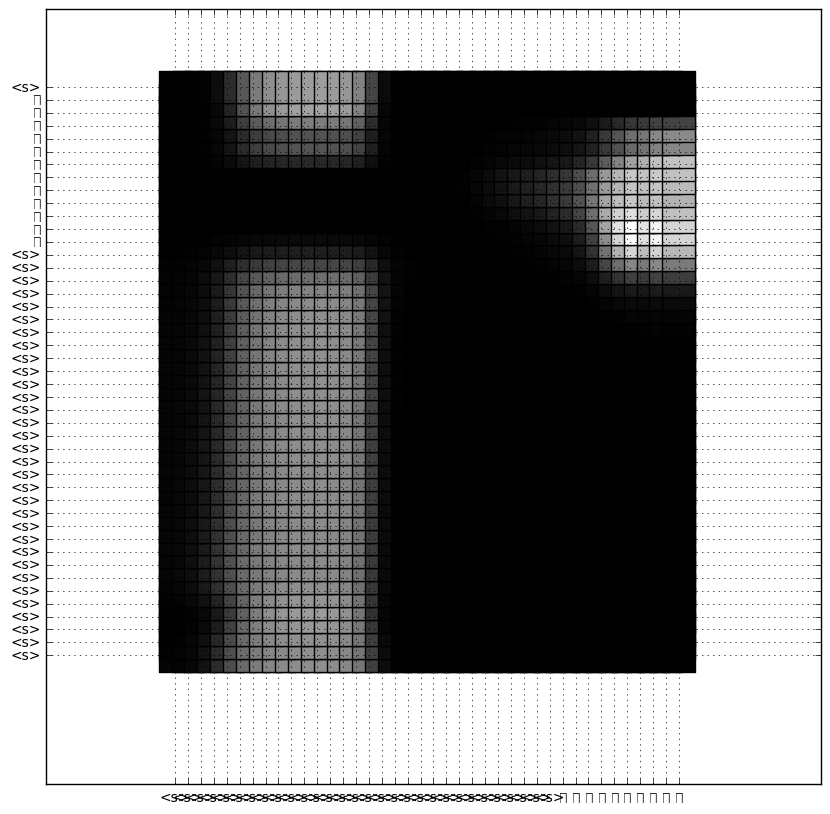

In [51]:
i = 1
plt.gray()
fig = plt.figure(figsize=(10, 10), dpi= 80)
ax  = plt.subplot(111, aspect='equal')
ax.scatter(
    np.tile(np.arange(T_x), T_y),
    np.tile(np.arange(T_y), (T_x,1)).T.reshape(T_y*T_x),
    s=560,
    marker='s',
    c=(alphas[i].flatten())
)
ax.set_xticks(np.arange(T_x))
ax.set_yticks(np.arange(T_y))
ax.set_xticklabels(np.array(char_array)[test_srcs[i]])
ax.set_yticklabels(np.array(char_array)[np.concatenate([test_trgs[i][1:], np.array([0])])])
#ax.gray()
print(np.array(char_array)[test_srcs[i]])
print(np.array(char_array)[np.concatenate([test_trgs[i][1:], np.array([0])])])

plt.grid()
plt.show()


In [52]:
#!jupyter nbconvert --to script encoder-decoder-attention.ipynb --output encoder-decoder-attention